In [0]:
import pickle
import pandas as pd
with open('data', 'rb') as f:
  data = pickle.load(f)

In [4]:
data.head(2)


,English,french
0,"new jersey is sometimes quiet during autumn , ...",new jersey est parfois calme pendant l' automn...
1,the united states is usually chilly during jul...,les états-unis est généralement froid en juill...


In [0]:
# Vocabulary of English
all_eng_words=[]
for eng in data.English:
    for word in eng.split():
        if word not in all_eng_words:
            all_eng_words.append(word)

# Vocabulary of French 
all_french_words=[]
for mar in data.french:
    for word in mar.split():
        if word not in all_french_words:
            all_french_words.append(word)

In [0]:
all_eng_words = list(set(all_eng_words))

In [0]:
all_french_words = list(set(all_french_words))

In [8]:
import numpy as np
lenght_list=[]
for l in data.English:
    lenght_list.append(len(l.split(' ')))
max_length_src = np.max(lenght_list)
max_length_src

17

In [9]:
lenght_list=[]
for l in data.french:
    lenght_list.append(len(l.split(' ')))
max_length_tar = np.max(lenght_list)
max_length_tar

23

In [10]:

#All input words
input_words = sorted(list(all_eng_words))
target_words = sorted(list(all_french_words))

# get the length of the vocabalary // Kitne words // this will help while performing embedding layer
num_encoder_tokens = len(all_eng_words) + 1
num_decoder_tokens = len(all_french_words) + 1

num_encoder_tokens, num_decoder_tokens

(228, 356)

In [0]:
input_token_index = dict([(word, i+1) for i, word in enumerate(input_words)])
target_token_index = dict([(word, i+1) for i, word in enumerate(target_words)])

In [12]:
#Tokenizing the source sentences
input_token_index


#Tokenizing the target sentences French
target_token_index

{',': 1,
 '-': 2,
 '-ce': 3,
 '-elle': 4,
 '-il': 5,
 '-ils': 6,
 '.': 7,
 '?': 8,
 'a': 9,
 'agréable': 10,
 'aimait': 11,
 'aime': 12,
 'aiment': 13,
 'aiment-ils': 14,
 'aimeraient': 15,
 'aimez': 16,
 'aimons': 17,
 'aimé': 18,
 'aimé.': 19,
 'aimée': 20,
 'aimés': 21,
 'aller': 22,
 'allez': 23,
 'allions': 24,
 'allons': 25,
 'allé': 26,
 'allée': 27,
 'allés': 28,
 'amusant': 29,
 'anglais': 30,
 'animal': 31,
 'animaux': 32,
 'août': 33,
 'apprécié': 34,
 'as-tu': 35,
 'at': 36,
 'au': 37,
 'automne': 38,
 'automobile': 39,
 'aux': 40,
 'avez': 41,
 'avons': 42,
 'avril': 43,
 'banane': 44,
 'bananes': 45,
 'beau': 46,
 'belle': 47,
 'bien': 48,
 'blanc': 49,
 'blanche': 50,
 'bleu': 51,
 'bleue': 52,
 'brillant': 53,
 'brillante': 54,
 'bénigne': 55,
 "c'est": 56,
 'california': 57,
 'californie': 58,
 'calme': 59,
 'camion': 60,
 'ce': 61,
 'cet': 62,
 'cette': 63,
 'chat': 64,
 'chats': 65,
 'chaud': 66,
 'chaude': 67,
 'chaux': 68,
 'cher': 69,
 'cheval': 70,
 'chevaux': 71

In [0]:

reverse_input_char_index = dict((i, word) for word, i in input_token_index.items())
reverse_target_char_index = dict((i, word) for word, i in target_token_index.items())

In [14]:
from sklearn.utils import shuffle
data = shuffle(data)
data.head()

,English,french
13118,"paris is usually chilly during winter , but it...",paris est généralement froid pendant l' hiver ...
84784,"china is sometimes cold during january , and i...","chine est parfois froid en janvier , et il ple..."
53341,"india is usually cold during october , but it ...","l' inde est généralement froid en octobre , ma..."
79955,"california is wet during autumn , but it is so...","californie est humide à l'automne , mais il es..."
55502,"they dislike strawberries , limes , and pears .","ils n'aiment les fraises , citrons verts , et ..."


In [43]:
# Train - Test Split
from sklearn.model_selection import train_test_split
X, y = data.English, data.french
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)
X_train.shape, X_test.shape

((124074,), (13786,))

In [0]:
def generate_batch(X=X_train, y=y_train, batch_size=1000):
    while True:
      # in every batch we are sending (batch_size) of sentences
        for j in range(0, len(X), batch_size):
            encoder_input_data = np.zeros((batch_size, max_length_src),
                    dtype='float32')
            decoder_input_data = np.zeros((batch_size, max_length_tar),
                    dtype='float32')
            decoder_target_data = np.zeros((batch_size, max_length_tar,
                    num_decoder_tokens), dtype='float32')

            # for all the sentences in the batch
            for (i, (input_text, target_text)) in enumerate(zip(X[j:j
                    + batch_size], y[j:j + batch_size])):

                # for words in each sentence //English
                for (t, word) in enumerate(input_text.split()):  # English wale text ko tokenize kiya gaya
                    encoder_input_data[i] = input_token_index[word]  # encoder input seq

                # for each word in French Sentence
                for (t, word) in enumerate(target_text.split()):  # t is the length of the sentence
                    if t < len(target_text.split()):
                        decoder_input_data[i] = target_token_index[word]  # decoder input seq
                    if t > 0:
                        #one-hot encoding 
                        #and making it to the output shape from decoder
                        decoder_target_data[i, t - 1,
                                target_token_index[word]] = 1.
                                                       
            yield ([encoder_input_data, decoder_input_data],
                   decoder_target_data)  # this will help multiple return// like closure in swift


In [17]:
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional,CuDNNLSTM,Concatenate
from keras.layers import Input, LSTM, Embedding, Dense
from keras.models import Model
# Encoder
latent_dim = 64 # how much dimension of output we want form the embedding layer
encoder_inputs = Input(shape=(None,)) # mentioning the input shape row and collumns are still null

# **num_encoder_tokens** vocabulary size we are having
enc_emb =  Embedding(num_encoder_tokens, latent_dim, mask_zero = True)(encoder_inputs) #Embedding layer # this layer will make it 3D

#training the LSTM on encoder
# encoder_lstm = LSTM(latent_dim, return_state=True)
lstm, forward_h, forward_c, backward_h, backward_c = Bidirectional(LSTM(128, return_sequences=True, return_state=True))(enc_emb)
state_h = Concatenate()([forward_h, backward_h])
state_c = Concatenate()([forward_c, backward_c])
# encoder_outputs, state_h, state_c = encoder_lstm(enc_emb) #output


encoder_states = [state_h, state_c] #output and the cell state

Using TensorFlow backend.





Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:

#  Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,)) #french's input
dec_emb_layer = Embedding(num_decoder_tokens, latent_dim, mask_zero = True) 
dec_emb = dec_emb_layer(decoder_inputs) # french sikhaye hum Embedding layer ko


# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.


decoder_lstm = LSTM(256, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(dec_emb,initial_state=encoder_states)

decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [19]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [20]:
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 64)     14592       input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) [(None, None, 256),  197632      embedding_1[0][0]                
____________________________________________________________________________________________

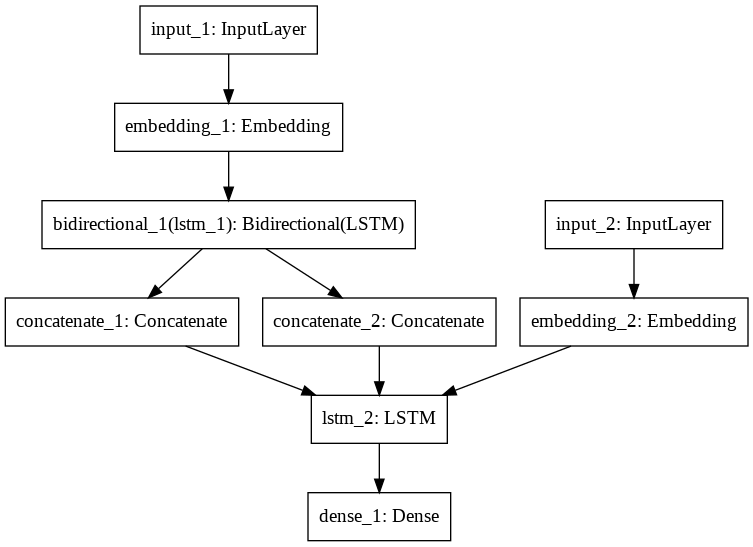

In [21]:
from keras.utils import plot_model
plot_model(model, to_file='multilayer_perceptron_graph.png')

In [44]:
import numpy as np
model.fit_generator(generator = generate_batch(X_train, y_train, batch_size = 100),
                    steps_per_epoch = 5000,
                    epochs=1,
                    validation_data = generate_batch(X_test, y_test, batch_size = 100),
                    validation_steps = 5000 
                    )

Epoch 1/1
5000/5000 [==============================] - 866s 173ms/step - loss: 1.7789 - acc: 0.1475 - val_loss: 1.7693 - val_acc: 0.1501


In [0]:
model.save_weights('nmt_weights.h5')

In [0]:
model.load_weights('nmt_weights.h5')

___

In [0]:
#Making new model so that we can predict the output
# taking all input and output of the encoder from the previous model to here
    #encoder_inputs: It's the tokenized and padded words from the english
encoder_model = Model(encoder_inputs, encoder_states) 

#giving input to decoder
decoder_state_input_h = Input(shape=(256,)) # this will be the input form the encoders # cz 256 is from the encoder after concatination 
decoder_state_input_c = Input(shape=(256,)) #cell state after the encoder

decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

#french words tokenized
dec_emb2= dec_emb_layer(decoder_inputs) #Get the embeddings of the decoder sequence

#decoder ka output and cell state nikal liya 
    # decoder_lstm = LSTM(256, return_sequences=True, return_state=True)
        # here dec_emb2 we passed the output from the embedding later which for trained on tokenized sentensed of french words
decoder_outputs, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)

#added both states from the decoder 
decoder_states = [state_h2, state_c2]  

# Passing the output from the decoder model to the dense layer
decoder_output_dense = decoder_dense(decoder_outputs)

# Final decoder model
# decoder_inputs : Embedding layer ko french sentence tokenizer
# decoder_states_inputs : this is from the encoder
# decoder_outputs2 : #ye decoder ka output he //predicted values from the decoder not the cellstate or output(h)
# decoder_states2 : #ye output(h) & cell state h 


decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_output_dense] + decoder_states)





In [40]:
print(decoder_model.summary())

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, None, 64)     22784       input_2[0][0]                    
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 256)          0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, 256)          0                                            
____________________________________________________________________________________________

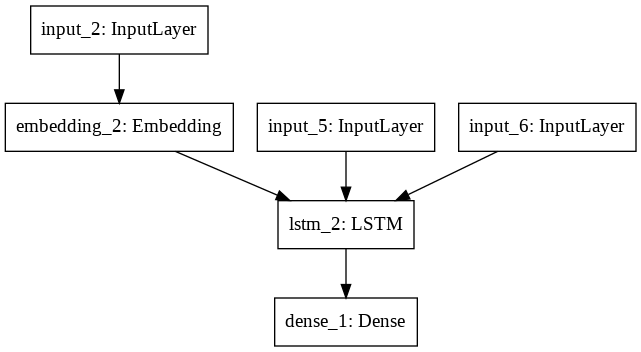

In [39]:
from keras.utils import plot_model
plot_model(decoder_model, to_file='multilayer_perceptron_graph.png')

In [0]:
def decode_sequence(input_seq): 
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    # Populate the first character of target sequence with the start character.
    print(target_token_index)
    # target_seq[0, 0] = target_token_index['Start_']

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += ' '+sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '_End' or
           len(decoded_sentence) > 50):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update states
        states_value = [h, c]

    return decoded_sentence

In [0]:
train_gen = generate_batch(X_train, y_train, batch_size = 1)
k=-1

In [0]:
X_train = 'Start_' + X_train + '_End'
X_test = 'Start_' + X_test + '_End'

In [30]:
X_train.head()

93514     Start_he likes grapefruit , limes , and apples...
75276        Start_he dislikes grapes and strawberries._End
40950     Start_france is never hot during august , and ...
15841     Start_you dislike grapefruit , oranges , and l...
103418    Start_the lemon is their favorite fruit , but ...
Name: English, dtype: object

In [0]:

(input_seq, actual_output), _ = next(train_gen)

In [35]:
k+=2
X_train[k:k+1]

40950    Start_france is never hot during august , and ...
Name: English, dtype: object

In [36]:
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Marathi Translation:', y_train[k:k+1].values[0][3:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

{',': 1, '-': 2, '-ce': 3, '-elle': 4, '-il': 5, '-ils': 6, '.': 7, '?': 8, 'a': 9, 'agréable': 10, 'aimait': 11, 'aime': 12, 'aiment': 13, 'aiment-ils': 14, 'aimeraient': 15, 'aimez': 16, 'aimons': 17, 'aimé': 18, 'aimé.': 19, 'aimée': 20, 'aimés': 21, 'aller': 22, 'allez': 23, 'allions': 24, 'allons': 25, 'allé': 26, 'allée': 27, 'allés': 28, 'amusant': 29, 'anglais': 30, 'animal': 31, 'animaux': 32, 'août': 33, 'apprécié': 34, 'as-tu': 35, 'at': 36, 'au': 37, 'automne': 38, 'automobile': 39, 'aux': 40, 'avez': 41, 'avons': 42, 'avril': 43, 'banane': 44, 'bananes': 45, 'beau': 46, 'belle': 47, 'bien': 48, 'blanc': 49, 'blanche': 50, 'bleu': 51, 'bleue': 52, 'brillant': 53, 'brillante': 54, 'bénigne': 55, "c'est": 56, 'california': 57, 'californie': 58, 'calme': 59, 'camion': 60, 'ce': 61, 'cet': 62, 'cette': 63, 'chat': 64, 'chats': 65, 'chaud': 66, 'chaude': 67, 'chaux': 68, 'cher': 69, 'cheval': 70, 'chevaux': 71, 'chien': 72, 'chiens': 73, 'chine': 74, 'chinois': 75, 'citron': 76,

In [0]:
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Marathi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])